# Deep learning tests

## Load libraries and data

In [153]:
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn
import torch.nn.functional
import torch.utils.data
import torchvision
import tqdm
data = scio.loadmat('tissue7_1.mat')

In [ ]:
# Look at imported data
for key, value in data.items():
    print(key)

In [ ]:
plt.imshow(data['tissue_t7_1'])
plt.figure()
plt.imshow(data['tissue_t7_2'])
print(data['map_t7_1'].shape)
print(data['map_t7_2'].shape)

In [158]:
target = data['tissue_t7_2'].copy()
tissue_data = data['map_t7_2']    

In [159]:
for i in range(200):
    for j in range(200):
        if target[i,j] == 5:
            target[i,j] = 1
        else:
            target[i,j] = 0

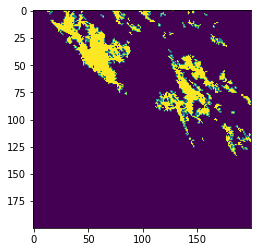

In [160]:
plt.imshow(target)

## Feedforward neural network

In [174]:
X = []
for i in range(200):
    for j in range(200):
        X.append(tissue_data[i,j,:])

y = []
for i in range(200):
    for j in range(200):
        y.append(target[i,j])

In [175]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2)

scaler = sklearn.preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [189]:
class FeedforwardNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(1024, 1000) 
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(1000, 1000)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(1000, 1000)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(1000, 1000)
        self.relu4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(1000, 2)
        self.softmax = torch.nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.fc1(x)
        output = self.relu1(output)
        output = self.fc2(output)
        output = self.relu2(output)
        output = self.fc3(output)
        output = self.relu3(output)
        output = self.fc4(output)
        output = self.relu4(output)
        output = self.fc5(output)
        output = self.softmax(output)
        return output

In [190]:
model = FeedforwardNeuralNetwork()

In [191]:
tensor_X_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train).long()

dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
        sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=10000, drop_last=False))

In [192]:
criterion = torch.nn.CrossEntropyLoss() 

learning_rate = 0.1
num_epochs = 500

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [193]:
model.train();

In [194]:
loss_history = []
accuracy_history = []
for epoch in tqdm.trange(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        correct = (torch.argmax(y_pred, dim=1) == targets).type(torch.FloatTensor)
        accuracy_history.append(correct.mean())

100%|██████████| 500/500 [21:39<00:00,  2.60s/it]


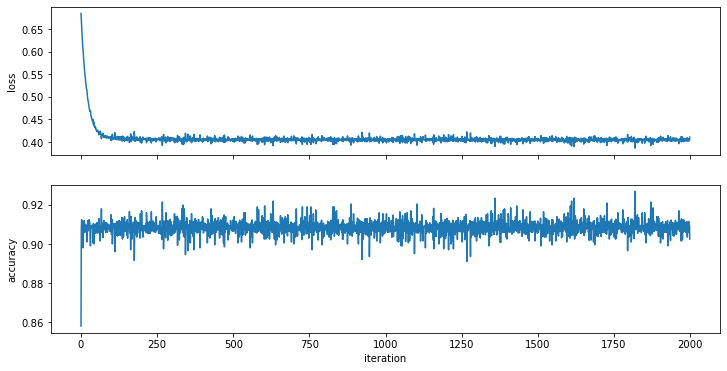

In [195]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_history)
ax1.set_ylabel('loss')
ax2.plot(accuracy_history)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration');

### Let's see how the model does...

In [196]:
model.eval();

In [197]:
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test).long()

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [198]:
y_pred_test

tensor([[9.9999e-01, 1.4680e-05],
        [9.9999e-01, 1.2955e-05],
        [9.9999e-01, 9.9560e-06],
        ...,
        [9.9998e-01, 2.2463e-05],
        [9.8172e-01, 1.8284e-02],
        [1.0000e+00, 2.4987e-09]], grad_fn=<SoftmaxBackward0>)

In [200]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        index = i*200 + j
        approximation[i,j] = results[index]

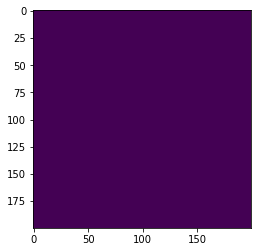

In [201]:
plt.imshow(approximation)